<a href="https://colab.research.google.com/github/kmk3593/google_drive/blob/main/hg_chapter8/chapter_8_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08-2. 합성곱 신경망을 이용한 이미지 분류

### 패션 MNIST 데이터 불러오기
- 데이터 스케일을 0 ~ 255 사이 0 ~ 1 로 표준화
- 훈련 데이터 / 검증 데이터 분류
- 완전 연결 신경망 (Fully Connected Layer)
--> 2차원 배열 -> 1차원 배열 (최종 분류값 도출)
--> 완전 연결 신경망과 달리, 합성곱에서는 2차원 이미지를 그대로 사용한다.

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


### 합성곱 신경망 만들기
- 446p
- 437p 그림을 코드로 구현하는 내용

In [3]:
model = keras.Sequential()
# 합성곱 층
model.add(keras.layers.Conv2D(32, kernel_size=3, activation = 'relu',        # Conv2D() 는 합성곱 층을 만든다.
                              padding = 'same', input_shape = (28, 28, 1)))  # 합성곱의 필터 32이므로 특성 맵의 깊이는 32 

# 풀링층
model.add(keras.layers.MaxPooling2D(2))                                      # (2,2) 풀링을 적용하여 합성곱 층의 특성 맵의 크기가 절반이 된다.
                                                                             
# 합성곱 층
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation = 'relu',    # 합성곱의 필터 64이므로 특성 맵의 깊이는 64
                              padding = 'same'))

# 풀링층
model.add(keras.layers.MaxPooling2D(2))                                      # (2,2) 풀링을 적용하여 합성곱 층의 특성 맵의 크기가 절반이 된다.
                                                                             
# 완전연결층 (밀집층 = Fully Connected Layer)
# Chapter 7장 내용
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))                        # 은닉층
model.add(keras.layers.Dropout(0.4))                                         # 드롭아웃 -> 과대 적합  방지
model.add(keras.layers.Dense(10, activation='softmax'))                      # 출력측

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

- 필터의 개수에 따라 특성 맵의 크기는
  - 첫 번째 합성곱 층을 통과하면서 특성 맵의 크기가 32가 된다.
  - 두 번째 합성곱에서 특성 맵의 크기가 64로 늘어난다.
- 반면 특성 맵의 가로세로 크기는
  - 첫 번째 풀링 층에서 절반으로 줄어든다.
  - 두 번째 풀링층에서 다시 절반으로 더 줄어든다.
- Flatten 클래스에서 (7,7,64) 크기의 특성 맵을 1차원 배열로 펼친다.
  - (7,7,64) -> (3136,) 

모델 파라미터 개수 계산
- 첫 번째 합성곱 층
  - 32개 필터, 커널 크기(3,3), 깊이1, 필터마다 하나의 절편 -> 3x3x1x32 + 32 = 320개
- 두 번째 합성곱 층
  - 64개 필터, 커널 크기(3,3), 깊이32, 필터마다 하나의 절편 -> 3x3x32x64 + 64 = 18,496개
- Flatten 즉, 은닉층
  - (3136,) 개의 1차원 배열, 100개의 뉴런 -> 3136x100 + 100 = 313,700개

 - 텐서플로 : https://www.tensorflow.org/hub
  - 필요한 것을 찾아서 가져다 사용할 수 있다.

- 층의 구성을 그림으로 표현해 본다.
- keras.uitls 패키지의 plot_model() 함수 사용

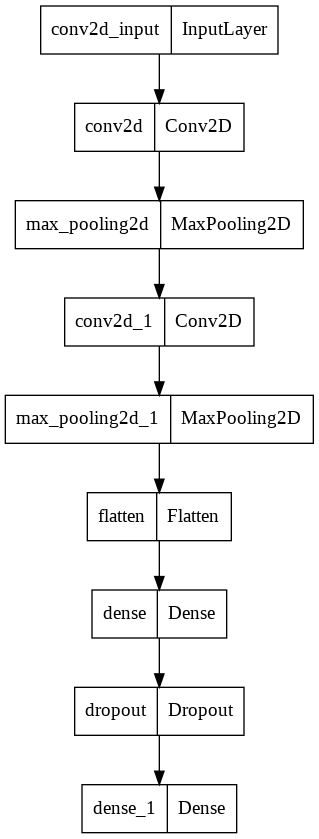

In [4]:
keras.utils.plot_model(model)

- 박스 안에서
  - 왼쪽 : 층의 이름
  - 오른쪽 : 클래스
- inputLayer 클래스
  - 케라스가 자동으로 추가해주는 입력층의 역할.
  - Conv2D 클래스의 input_shape 매개변수를 사용.

- 층의 구성을 그림으로 표현해 본다.
- keras.uitls 패키지의 plot_model() 함수 사용
- show_shapes 매개변수를 True로 설정하면 그림에 입력과 출력의 크기를 표시한다.

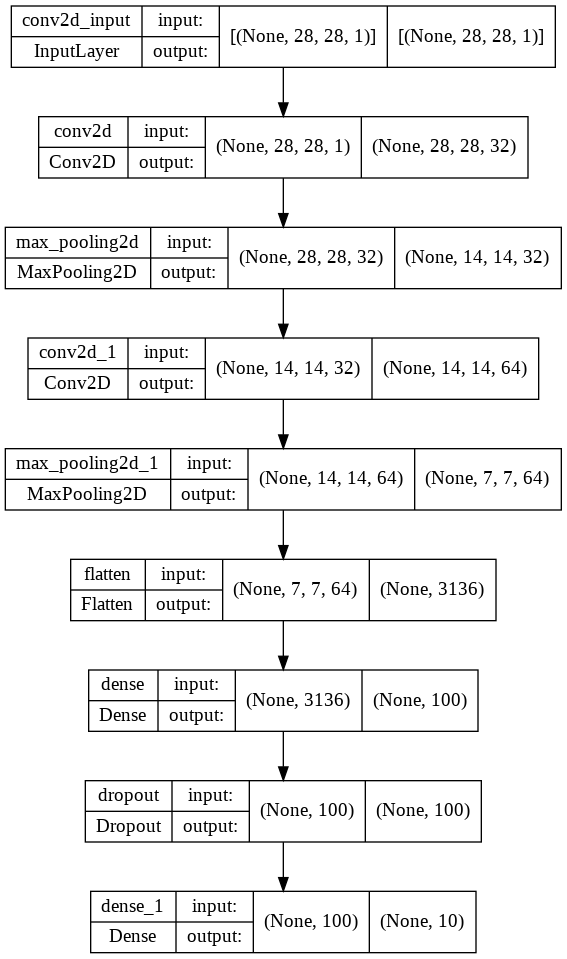

In [5]:
keras.utils.plot_model(model, show_shapes = True)

- 지금까지 한 것은 모델 정의
- 모델 컴파일 후, 훈련 
  - 7장 내용
  - Adam 옵티마이저를 사용
  - 조기 종료 기법을 구현 : ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용한다.

In [6]:
import tensorflow as tf
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

with tf.device('/device:GPU:0'):      # GPU 잡는 법
  history = model.fit(train_scaled, train_target, epochs=10,
                      validation_data=(val_scaled, val_target),
                      callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
1500/1500 [==============================] - 59s 39ms/step - loss: 0.4968 - accuracy: 0.8231 - val_loss: 0.3245 - val_accuracy: 0.8799
Epoch 2/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.3304 - accuracy: 0.8809 - val_loss: 0.2726 - val_accuracy: 0.8967
Epoch 3/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.2833 - accuracy: 0.8987 - val_loss: 0.2461 - val_accuracy: 0.9072
Epoch 4/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.2534 - accuracy: 0.9069 - val_loss: 0.2360 - val_accuracy: 0.9119
Epoch 5/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.2311 - accuracy: 0.9165 - val_loss: 0.2258 - val_accuracy: 0.9170
Epoch 6/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.2104 - accuracy: 0.9224 - val_loss: 0.2346 - val_accuracy: 0.9157
Epoch 7/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.1916 - accuracy: 0.9275 - val_loss: 0.2132 -

- 훈련 세트의 정확도가 이전에 비해 증가했다.
- 손실 그래프를 그린다.
  - 조기 종료가 잘 이루어졌는지 확인하자.



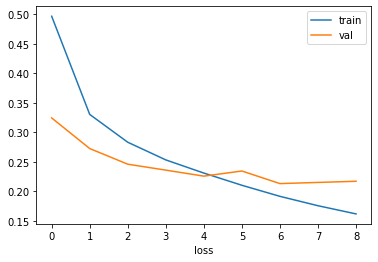

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.xlabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 그래프를 기반으로 9번째 에포크를 최적으로 생각할 수 잇다.
- 세트에 대한 성능을 평가해본다.

In [8]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 5s 14ms/step - loss: 0.2132 - accuracy: 0.9234


[0.21322399377822876, 0.9234166741371155]

- 좌측 파일 선택 -> best-cnn-model.h5 다운로드

# 08-3. 합성곱 신경망 시각화
- 교재 465p
- 사전 학습 = 이전에 만든 모델이 어떤 가중치를 학습했는지 확인하기 위해 체크포인트 파일을 읽는다.
- model.layers 
  - 케라스 모델에 추가한 층을 출력한다.

In [9]:
from tensorflow import keras

# 사전학습 진행
model2 = keras.models.load_model("best-cnn-model.h5")

#keras.utils.plot_model(model2, show_shapes = True)
model.layers

- 합성곱 층의 가중치를 확인 가능
- 우선 첫 번째 합성곱 층의 가중치를 조사한다.

In [10]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape) # 가중치, 절편

(3, 3, 1, 32) (32,)


In [11]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())      # 가중치 배열의 평균, 표쥰편차 

-0.038952995 0.26509935


- 이 가중치가 어떤 분표를 가졌는지 보기 쉽게 히스토그램으로 그린다.

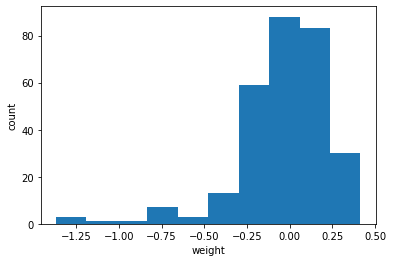

In [12]:
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

- 이 가중치가 어떤 의미인지 시각화 해보자.
- 468p
- 32개의 커널을 16개씩 2줄로 출력한다.

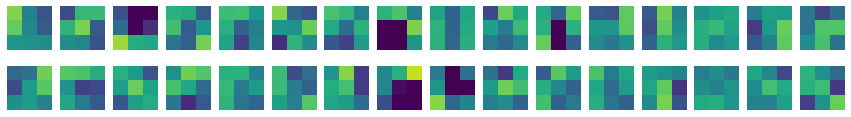

In [13]:
ig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5) # vmin, vmax는 맷플롯립의 컬러맵으로 표현할 범위를 지정
        axs[i, j].axis('off')

plt.show()

- 색이 밝은지 어두운지를 통해 가중치를 판단할 수 있다.

 이번에는 훈련하지 않은 빈 합성곱 신경망을 만든다.
 - 먼저 Conv2D 층을 하나 추가한다.

In [14]:
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                                          padding='same', input_shape=(28,28,1)))

- 첫 번째 Conv2D층의 가중치를 no_training_conv 변수에 저장한다.

In [15]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


- 가중치의 평균과 표준편차를 확인한다.

In [16]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

0.011464282 0.08503365


- 이 가중치 배열을 히스토그램으로 표현한다.

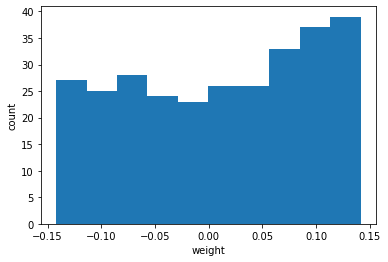

In [17]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

- 그래프가 이전과 확실히 다르다.
- 이 가중치 값을 맷플롯립의 imshow() 함수를 사용해 이전처럼 그림으로 출력한다.

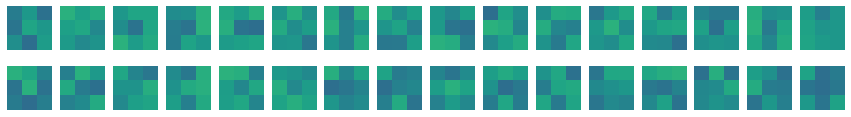

In [18]:
ig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5) # vmin, vmax는 맷플롯립의 컬러맵으로 표현할 범위를 지정
        axs[i, j].axis('off')

plt.show()

- 전체적으로 가중치가 밋밋하게 초기화되었다.
- 이 그림을 훈련이 끝난 이전 가중치와 비교해보자.
- 합성곱 신경망이 패현MNIST 데이터셋의 부류 정확도를 높이기 위해 유용한 패턴을 학습했다는 사실을 눈치챌 수 있다.

### 함수형 API
- 474p
- 특성 맵 시각화
  - 케라스로 패현 MNIST 데이터셋을 읽은 후 훈련 세트에 있는 첫 번째 샘플을 그려본다.

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


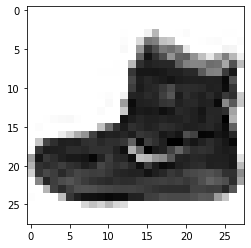

In [19]:
print(model.input)
conv_acti = keras.Model(model.input, model.layers[0].output)
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

- 앵클 부트다.
- 이 샘플을 conv_acti 모델에 주입하여 Conv2D 층이 만드는 특성 맵을 출력한다.
- 08-2장에서 했던 것처럼 전처리를 진행한다.
- feature_maps의 크기를 확인한다.

In [20]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0
feature_maps = conv_acti.predict(inputs)
print(feature_maps.shape)

(1, 28, 28, 32)


- same 패딩과 32개의 필터를 사용한 합성곱 층의 출력이므로 (28,28,32)이다.
- 샘플을 하나 입력했기에 1이다.
- 앞에서와 같이 맷플롯립의 imshow함수로 특성 맵을 그린다.
  - 32개의 특성 맵을 4개의 행으로 나누어 그린다.

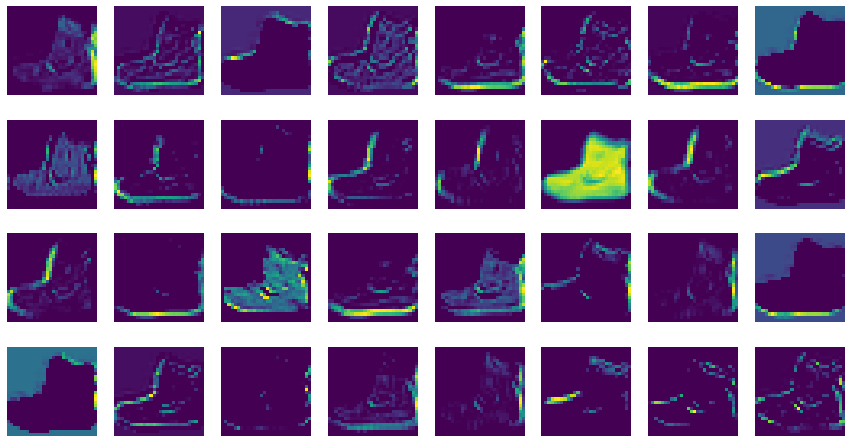

In [21]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

- 두 번째 합성곱 층이 많든 특성 맵도 같은 방식으로 확인할 수 있다.
- 먼저 model 객체의 입력과 두 번째 합성곱 층인 model.layers[2]의 출력을 연결한 conv2_acti 모델을 만든다.
- 그 다음 첫 샘플을 conv2_acti 모델의 predict() 메서드에 전달한다.
- 첫 번째 풀링 층에서 가로세로 크기가 줄반으로 줄고, 두 번째 합성곱 층의 필터 개수는 64개이므로 (14,14,64) 가 된다.
- 64개의 특성 맵을 8개씩 나누어 imshow()함수로 그린다.

(1, 14, 14, 64)


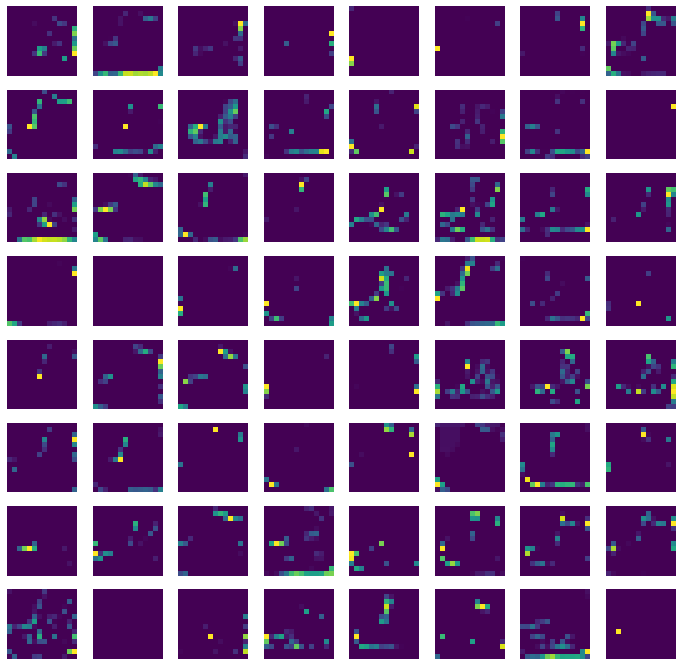

In [22]:
conv2_acti = keras.Model(model.input, model.layers[2].output)
feature_maps = conv2_acti.predict(train_input[0:1].reshape(-1, 28, 28, 1)/255.0)
print(feature_maps.shape)

fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

- 이번 특성 맵은 시각적으로 이해하기 어렵다.
- 두 번째 합성곱 층의 필터 크기는 (3,3,32)인데 (14,14,32)인 특성 맵에서 어떤 부위를 감지하는지 직관적으로 이해하기 어렵다.
  - 478p 그림 참고
- 이런 현상은 합성곱 층을 많이 쌓을수록 심해진다.

- Reference : 혼자 공부하는 머신러닝 + 딥러닝